# Figures for joint microstate model


This compares performance of models trained on the joint probabilities P(m,n) using Hellinger distance.


It includes

1. Varying number of kernel density functions
2. Varying number of nodes

It finally shows how we selection of the best model based on validation data. 

In [2]:
import sys,os

# insert path to where training modules are stored
sys.path.insert(0,'../trainingModules/')
sys.path.insert(0,'./psKWR/')

# import other packages! 
import numpy as np
import scipy
import scipy.stats as stats
import torch
import pickle

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import trainers_2 as tm2 
import models as models

cpu


In [3]:
# load in models and results

all_paths = []
for p in os.listdir(f'./models/psKWR_models/learn_weights_scale_joint_hellinger/'):
    all_paths.append(f'./models/psKWR_models/learn_weights_scale_joint_hellinger/' + p)

# Figure S4


## Figure S4 a-i: performance on testing parameters, all models

In [4]:
# load in testing parameters
npdf = 10
num_files = 2
test_ds = tm2.burstyBernoulliDataset([f'./data/psKWR_data/{npdf}_npdf_cheb/256_params_{i}_test'
                                      for i in range(num_files)])

params_10 = test_ds.get_data_dict(None)['params']
cond_pss_10 = test_ds.get_data_dict(None)['cond_pss']

npdf = 5
test_ds = tm2.burstyBernoulliDataset([f'./data/psKWR_data/{npdf}_npdf_cheb/256_params_{i}_test'
                                      for i in range(num_files)])

params_5 = test_ds.get_data_dict(None)['params']
cond_pss_5 = test_ds.get_data_dict(None)['cond_pss']

npdf = 3
test_ds = tm2.burstyBernoulliDataset([f'./data/psKWR_data/{npdf}_npdf_cheb/256_params_{i}_test'
                                      for i in range(num_files)])

params_3 = test_ds.get_data_dict(None)['params']
cond_pss_3 = test_ds.get_data_dict(None)['cond_pss']


# SAME number of params/cond_pss each
N = min(len(params_3),len(params_5),len(params_10))
params_10 = params_10[:N,:]
params_5 = params_5[:N,:]
params_3 = params_3[:N,:]

cond_pss_10 = cond_pss_10[:N,:]
cond_pss_5 = cond_pss_5[:N,:]
cond_pss_3 = cond_pss_3[:N,:]

/Users/mariacarilli/grad/git/GCCP_2022/./psKWR/trainers_2.py:46: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  self.params = torch.tensor([data_list[i][0] for i in range(len(data_list))],dtype=torch.float32)


In [5]:
print(N)

32580


In [23]:
# calculate testing metrics
eps = 1e-18
kld_nn = np.ones((len(all_paths),N))
hell_nn = np.ones((len(all_paths),N))
mse_nn = np.ones((len(all_paths),N))

# over grid of length 300
m_limit = 300
m = torch.arange(m_limit)   

for i,path in enumerate(all_paths):
    print(i,path)
    if '10npdf' in path:
        params = params_10
        cond = cond_pss_10.detach().numpy() 
        n_vals = params_10[:,3]
        b,beta,gamma = 10**params_10[:,0],10**params_10[:,1],10**params_10[:,2]
        mu_n = b/beta
        var_n = (mu_n)*(b + 1)
        n_binom = mu_n**2/(var_n - mu_n)
        p_binom = mu_n/var_n
        # nascent marginal probability
        comb =  torch.lgamma(n_vals + n_binom) - torch.lgamma(n_binom) - torch.lgamma(n_vals + 1) 
        log_p_nascent = comb + n_binom*torch.log(p_binom) + n_vals*torch.log(1-p_binom)

    elif '5npdf' in path:
        params = params_5
        cond = cond_pss_5.detach().numpy()
        n_vals = params_5[:,3]
        b,beta,gamma = 10**params_5[:,0],10**params_5[:,1],10**params_5[:,2]
        mu_n = b/beta
        var_n = (mu_n)*(b + 1)
        n_binom = mu_n**2/(var_n - mu_n)
        p_binom = mu_n/var_n
        # nascent marginal probability
        comb =  torch.lgamma(n_vals + n_binom) - torch.lgamma(n_binom) - torch.lgamma(n_vals + 1) 
        log_p_nascent = comb + n_binom*torch.log(p_binom) + n_vals*torch.log(1-p_binom)

    elif '3npdf' in path:
        params = params_3
        cond = cond_pss_3.detach().numpy()
        n_vals = params_5[:,3]
        b,beta,gamma = 10**params_5[:,0],10**params_5[:,1],10**params_5[:,2]
        mu_n = b/beta
        var_n = (mu_n)*(b + 1)
        n_binom = mu_n**2/(var_n - mu_n)
        p_binom = mu_n/var_n
        # nascent marginal probability
        comb =  torch.lgamma(n_vals + n_binom) - torch.lgamma(n_binom) - torch.lgamma(n_vals + 1) 
        log_p_nascent = comb + n_binom*torch.log(p_binom) + n_vals*torch.log(1-p_binom)
        
    model = torch.load(path+'/MODEL')
    # predicted
    pred = model.get_cond_P(params, m_limit)
    pred = torch.exp(log_p_nascent[:,None])*pred
    pred = pred.detach().numpy()
    pred[pred<eps] += (eps - pred[pred<eps])
    cond[cond<eps] += (eps - cond[cond<eps])
    
    hell_nn[i,:] = np.sum( (np.sqrt(cond) - np.sqrt(pred))**2, axis = 1)/2
    mse_nn[i,:] = np.sum((cond-pred)**2, axis = 1)
    
    # normalize before calculating KLD
    cond = cond / (cond.sum(axis=1)[:,None])
    pred = pred / (pred.sum(axis=1)[:,None])
    kld_nn[i,:] = np.sum(cond * np.log(cond/pred), axis = 1)

# compare number of basis functions, hyp or scale, number of hidden layers, number of hidden nodes

0 ./models/psKWR_models/learn_weights_scale_joint_hellinger/5npdf_2hl_256hu_100bs_0.001lr_update_256
1 ./models/psKWR_models/learn_weights_scale_joint_hellinger/3npdf_2hl_256hu_100bs_0.001lr_no_update_256
2 ./models/psKWR_models/learn_weights_scale_joint_hellinger/10npdf_3hl_256hu_100bs_0.001lr_update_256
3 ./models/psKWR_models/learn_weights_scale_joint_hellinger/3npdf_2hl_256hu_100bs_0.001lr_update_256
4 ./models/psKWR_models/learn_weights_scale_joint_hellinger/10npdf_2hl_512hu_100bs_0.001lr_no_update_256
5 ./models/psKWR_models/learn_weights_scale_joint_hellinger/5npdf_2hl_512hu_100bs_0.001lr_update_256
6 ./models/psKWR_models/learn_weights_scale_joint_hellinger/3npdf_1hl_256hu_100bs_0.001lr_update_256
7 ./models/psKWR_models/learn_weights_scale_joint_hellinger/3npdf_2hl_128hu_100bs_0.001lr_no_update_256
8 ./models/psKWR_models/learn_weights_scale_joint_hellinger/3npdf_5hl_256hu_100bs_0.001lr_update_256
9 ./models/psKWR_models/learn_weights_scale_joint_hellinger/10npdf_4hl_256hu_100

In [24]:
# useful functions
def plot_cdf(array_list,name_list,colors,alpha,ax,legend=False):
    ''' Plot CDF of given arrays.
    '''
#     fig,ax = plt.subplots(1,1,figsize = (5,5))
    assert len(colors) >= len(name_list), "not enough colors!"
    for i,array in enumerate(array_list):
        x = np.sort(array)
        N = len(array)
        cdf_ = np.arange(N) / N
        if legend:
            ax.plot(x,cdf_,label=name_list[i],color=colors[i],alpha=alpha)
            ax.legend()
        else:
            ax.plot(x,cdf_,color=colors[i],alpha=alpha)
        
        


In [25]:
kld_list = [kld_nn[i,:] for i in range(len(all_paths))]
hell_list = [hell_nn[i,:] for i in range(len(all_paths))]
mse_list = [mse_nn[i,:] for i in range(len(all_paths))]


## Figure S4 a,b,c 

Plot mean Hellinger distance, KLD, and MSE with standard deviation for 200 testing parameters for models based on varying the number of nodes. 5 npdf, 3 npdf, and 10 npdf will be plotted separately.

In [75]:
hell_mean_array_ = np.ones((3,4))
hell_std_array_ = np.ones((3,4))
hell_5thp_array_ = np.ones((3,4))
hell_95thp_array_ = np.ones((3,4))

kld_mean_array_ = np.ones((3,4))
kld_std_array_ = np.ones((3,4))
kld_5thp_array_ = np.ones((3,4))
kld_95thp_array_ = np.ones((3,4))

mse_mean_array_ = np.ones((3,4))
mse_std_array_ = np.ones((3,4))
mse_5thp_array_ = np.ones((3,4))
mse_95thp_array_ = np.ones((3,4))

units = ['64hu','128hu','256hu','512hu']


for i,p in enumerate(all_paths):
    for n,npdf in enumerate(['3npdf','5npdf','10npdf']):
        if npdf in p:
            for h, hu in enumerate(units):
                if hu in p:
                    hell_mean_array_[n,h] = np.mean(hell_list[i])
                    hell_std_array_[n,h] = np.std(hell_list[i])
                    hell_5thp_array_[n,h] = np.percentile(hell_list[i],5)
                    hell_95thp_array_[n,h] = np.percentile(hell_list[i],95)
            
                    kld_mean_array_[n,h] = np.mean(kld_list[i])
                    kld_std_array_[n,h] = np.std(kld_list[i])
                    kld_5thp_array_[n,h] = np.percentile(kld_list[i],5)
                    kld_95thp_array_[n,h] = np.percentile(kld_list[i],95)
            
                    mse_mean_array_[n,h] = np.mean(mse_list[i])
                    mse_std_array_[n,h] = np.std(mse_list[i])
                    mse_5thp_array_[n,h] = np.percentile(mse_list[i],5)
                    mse_95thp_array_[n,h] = np.percentile(mse_list[i],95)
                    


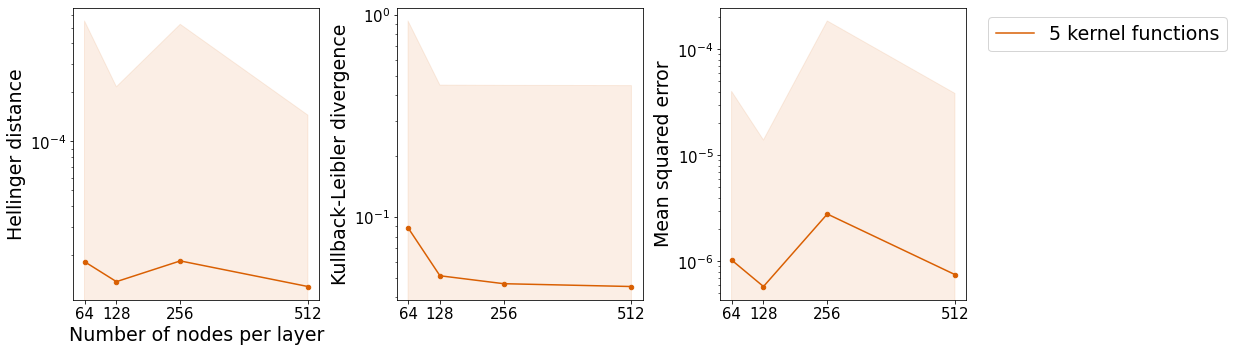

In [77]:
# and plot!! 
fs = 19
alpha = 0.1
fig,ax = plt.subplots(1,3,figsize=(18,5))

x = [64,128,256,512]
colors = ['#1b9e77','#d95f02','#7570b3','#e7298a']

# for n,node in enumerate(['3 kernel functions','5 kernel functions','10 kernel functions']):
for node in ['5 kernel functions']:
    n=1
    ax[0].plot(x,hell_mean_array_[n,:],label=node,color=colors[n])
    ax[0].scatter(x,hell_mean_array_[n,:],s=20,color=colors[n])
#     ax[0].errorbar(x,hell_mean_array_[n,:],yerr=hell_std_array_[n,:],)
    ax[0].fill_between(x,hell_mean_array_[n,:]-hell_std_array_[n,:],hell_mean_array_[n,:]+hell_std_array_[n,:],
                      alpha=alpha,color=colors[n])
    ax[0].set_ylabel('Hellinger distance',fontsize=fs)
    
    ax[1].plot(x,kld_mean_array_[n,:],label=node,color=colors[n])
    ax[1].scatter(x,kld_mean_array_[n,:],s=20,color=colors[n])
    ax[1].fill_between(x,kld_mean_array_[n,:]-kld_std_array_[n,:],kld_mean_array_[n,:]+kld_std_array_[n,:],
                      alpha=alpha,color=colors[n])
#     ax[1].fill_between(x,kld_5thp_array_[n,:],kld_95thp_array_[n,:],
#                       alpha=alpha,color=colors[n])
    ax[1].set_ylabel('Kullback-Leibler divergence',fontsize=fs)
    
    ax[2].plot(x,mse_mean_array_[n,:],label=node,color=colors[n])
    ax[2].scatter(x,mse_mean_array_[n,:],s=20,color=colors[n])
    ax[2].fill_between(x,mse_mean_array_[n,:]-mse_std_array_[n,:],mse_mean_array_[n,:]+mse_std_array_[n,:],
                      alpha=alpha,color=colors[n])
    ax[2].set_ylabel('Mean squared error',fontsize=fs)


for i in range(3):
    ax[i].tick_params(axis='both',labelsize=15)
    ax[i].set_xticks([64,128,256,512],labels=[64,128,256,512])
    ax[i].set_yscale('log')
    
ax[0].set_xlabel('Number of nodes per layer',fontsize=fs)
ax[2].legend(bbox_to_anchor=[2.1, 1.0],fontsize=fs)
plt.tight_layout();

## Figure S4 d,e,f

Plot metric mean and std varying number of npdf for different # npdf. 

In [ ]:
len()

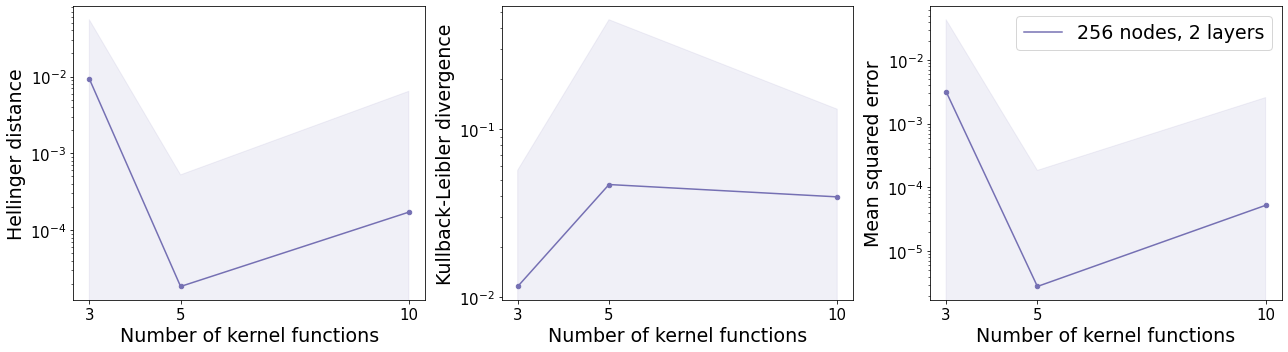

In [39]:
# and plot!! 
fs = 19
alpha = 0.1
fig,ax = plt.subplots(1,3,figsize=(18,5))

x = [3,5,10]
colors = ['#1b9e77','#d95f02','#7570b3','#e7298a']

# for n,node in enumerate(['64 nodes','128 nodes','256 nodes','512 nodes']):
for node in ['256 nodes, 2 layers']:
    n=2
    ax[0].plot(x,hell_mean_array_[:,n],label=node,color=colors[n])
    ax[0].scatter(x,hell_mean_array_[:,n],s=20,color=colors[n])
#     ax[0].errorbar(x,hell_mean_array_[n,:],yerr=hell_std_array_[n,:],)
    ax[0].fill_between(x,hell_mean_array_[:,n]-hell_std_array_[:,n],hell_mean_array_[:,n]+hell_std_array_[:,n],
                      alpha=alpha,color=colors[n])
    ax[0].set_ylabel('Hellinger distance',fontsize=fs)
    
    ax[1].plot(x,kld_mean_array_[:,n],label=node,color=colors[n])
    ax[1].scatter(x,kld_mean_array_[:,n],s=20,color=colors[n])
    ax[1].fill_between(x,kld_mean_array_[:,n]-kld_std_array_[:,n],kld_mean_array_[:,n]+kld_std_array_[:,n],
                      alpha=alpha,color=colors[n])
    ax[1].set_ylabel('Kullback-Leibler divergence',fontsize=fs)
    
    ax[2].plot(x,mse_mean_array_[:,n],label=node,color=colors[n])
    ax[2].scatter(x,mse_mean_array_[:,n],s=20,color=colors[n])
    ax[2].fill_between(x,mse_mean_array_[:,n]-mse_std_array_[:,n],mse_mean_array_[:,n]+mse_std_array_[:,n],
                      alpha=alpha,color=colors[n])
    ax[2].set_ylabel('Mean squared error',fontsize=fs)


for i in range(3):
    ax[i].tick_params(axis='both',labelsize=15)
    ax[i].set_xticks([3,5,10],labels=[3,5,10])
    ax[i].set_yscale('log')
    ax[i].set_xlabel('Number of kernel functions',fontsize=fs)
    
ax[2].legend(bbox_to_anchor=[1.0, 1.0],fontsize=fs)
plt.tight_layout();

## Figure S4 g,hi, 

Vary number of layers.

In [40]:
hell_mean_array_layers = np.ones((3,5))
hell_std_array_layers = np.ones((3,5))

kld_mean_array_layers = np.ones((3,5))
kld_std_array_layers = np.ones((3,5))

mse_mean_array_layers = np.ones((3,5))
mse_std_array_layers = np.ones((3,5))

layers = ['1hl','2hl','3hl','4hl','5hl']
for i,p in enumerate(all_paths):
    for n,npdf in enumerate(['3npdf','5npdf','10npdf']):
        if npdf in p:
            for h, hl in enumerate(layers):
                if hl in p:
                    hell_mean_array_layers[n,h] = np.mean(hell_list[i])
                    hell_std_array_layers[n,h] = np.std(hell_list[i])
            
                    kld_mean_array_layers[n,h] = np.mean(kld_list[i])
                    kld_std_array_layers[n,h] = np.std(kld_list[i])
            
                    mse_mean_array_layers[n,h] = np.mean(mse_list[i])
                    mse_std_array_layers[n,h] = np.std(mse_list[i])

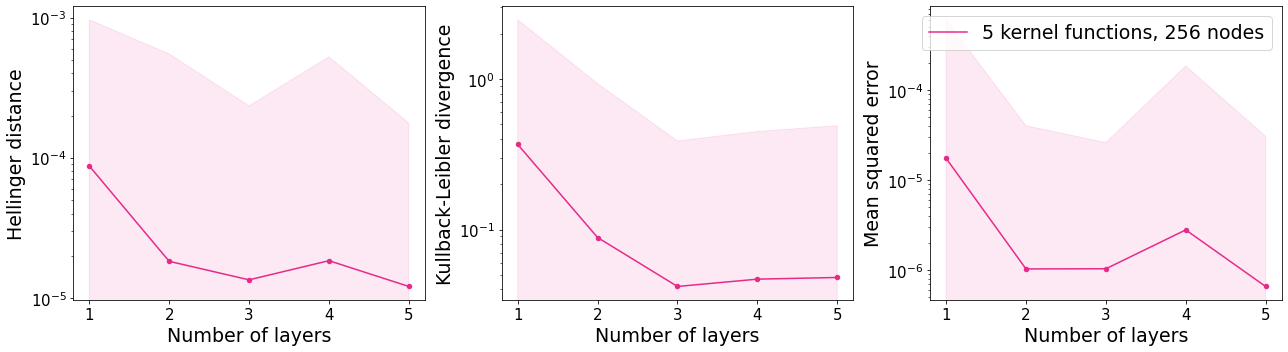

In [73]:
# and plot!! 
fs = 19
alpha = 0.1
fig,ax = plt.subplots(1,3,figsize=(18,5))


# colors = ['#1b9e77','#d95f02','#7570b3','#e7298a']
colors = ['#7570b3','#e7298a']

x = [1,2,3,4,5]
# for n,node in enumerate(['64 nodes','128 nodes','256 nodes','512 nodes']):
for layer in ['5 kernel functions, 256 nodes']:
    n=1
    ax[0].plot(x,hell_mean_array_layers[n,:],label=layer,color=colors[n])
    ax[0].scatter(x,hell_mean_array_layers[n,:],s=20,color=colors[n])
#     ax[0].errorbar(x,hell_mean_array_[n,:],yerr=hell_std_array_[n,:],)
    ax[0].fill_between(x,hell_mean_array_layers[n,:]-hell_std_array_layers[n,:],
                       hell_mean_array_layers[n,:]+hell_std_array_layers[n,:],
                      alpha=alpha,color=colors[n])
    ax[0].set_ylabel('Hellinger distance',fontsize=fs)
    
    ax[1].plot(x,kld_mean_array_layers[n,:],label=layer,color=colors[n])
    ax[1].scatter(x,kld_mean_array_layers[n,:],s=20,color=colors[n])
#     ax[0].errorbar(x,hell_mean_array_[n,:],yerr=hell_std_array_[n,:],)
    ax[1].fill_between(x,kld_mean_array_layers[n,:]-kld_std_array_layers[n,:],
                       kld_mean_array_layers[n,:]+kld_std_array_layers[n,:],
                      alpha=alpha,color=colors[n])
    ax[1].set_ylabel('Kullback-Leibler divergence',fontsize=fs)
    
    ax[2].plot(x,mse_mean_array_layers[n,:],label=layer,color=colors[n])
    ax[2].scatter(x,mse_mean_array_layers[n,:],s=20,color=colors[n])
#     ax[0].errorbar(x,hell_mean_array_[n,:],yerr=hell_std_array_[n,:],)
    ax[2].fill_between(x,mse_mean_array_layers[n,:]-mse_std_array_layers[n,:],
                       mse_mean_array_layers[n,:]+mse_std_array_layers[n,:],
                      alpha=alpha,color=colors[n])
    ax[2].set_ylabel('Mean squared error',fontsize=fs)


for i in range(3):
    ax[i].tick_params(axis='both',labelsize=15)
    ax[i].set_xticks(x,labels=x)
    ax[i].set_yscale('log')
    ax[i].set_xlabel('Number of layers',fontsize=fs)
    
ax[2].legend(bbox_to_anchor=[1.0, 1.0],fontsize=fs)
plt.tight_layout();

## Figure S4 j,k,l,m,n,o


Plot CDF on all testing parameters 

In [49]:
def get_name(p):
    
    p1 = p.split('joint_hellinger/')[1][:15]
    npdf = p1.split('npdf')[0]
    hl = p1.split('hl')[0][-1:]
    p2 = p1.split('_')[2]
    hu = p2.split('h')[0]
    
    return(npdf + ' kernel functions, ' + hl + ' layers, ' + hu + ' nodes')
    
names = [get_name(p) for p in all_paths]

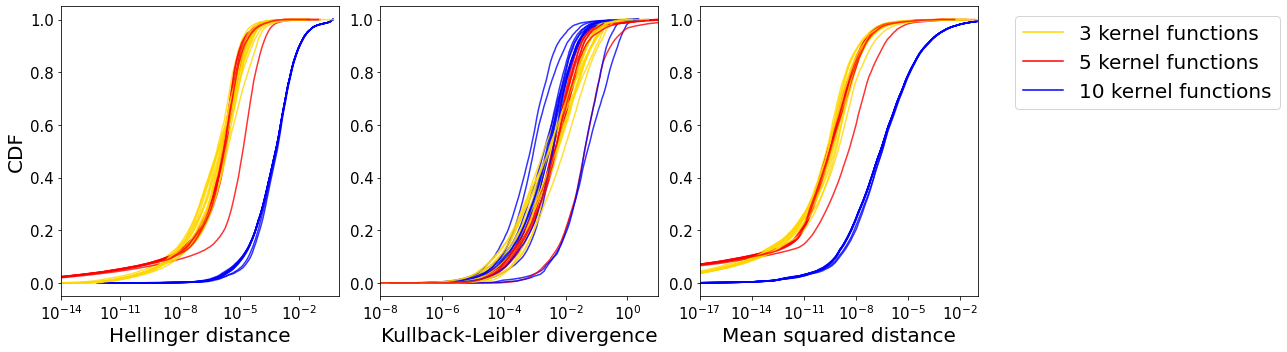

In [72]:
# color by number of nodes
# colors = ['red', 'green', 'blue', 'orange', 'purple', 'yellow',
#           'cyan', 'magenta', 'lime', 'pink', 'teal', 'indigo']

# # color by NPDF

alpha = 0.8
# color_options = ['#1b9e77','#d95f02','#7570b3','#e7298a']
color_options = ['gold','red','blue','green']
colors = []

for p in all_paths:
    if '10npdf' in p:
        colors.append(color_options[0])
    elif '5npdf' in p:
        colors.append(color_options[1])
    elif '3npdf' in p:
        colors.append(color_options[2])
     

    
fig,ax = plt.subplots(1,3,figsize=(18,5))
    
plot_cdf(hell_list,names,colors,alpha,ax[0],legend=False)
ax[0].set_xscale('log')
ax[0].set_xlim(10**-14,10**0)
ax[0].set_xlabel('Hellinger distance',fontsize=fs)
ax[0].set_ylabel('CDF',fontsize=fs)

plot_cdf(kld_list,names,colors,alpha,ax[1],legend=False)
ax[1].set_xscale('log')
ax[1].set_xlim(10**-8,10**1)
ax[1].set_xlabel('Kullback-Leibler divergence',fontsize=fs)
# ax[1].set_ylabel('CDF',fontsize=fs)

plot_cdf(mse_list,names,colors,alpha,ax[2],legend=False)
ax[2].set_xscale('log')
ax[2].set_xlim(10**-17,10**-1)
ax[2].set_xlabel('Mean squared distance',fontsize=fs)
ax[2].set_ylim(-0.05,1.05)
# ax[2].set_ylabel('CDF',fontsize=fs)

for n,npdf in enumerate(['3 kernel functions','5 kernel functions','10 kernel functions']):
    ax[2].plot([100,101],[100,101],label=npdf,color=color_options[n])

    
for i in range(3):
    ax[i].tick_params(axis='both',labelsize=15)
    

plt.legend(bbox_to_anchor=[1.1,1.0],fontsize=fs)
plt.tight_layout();

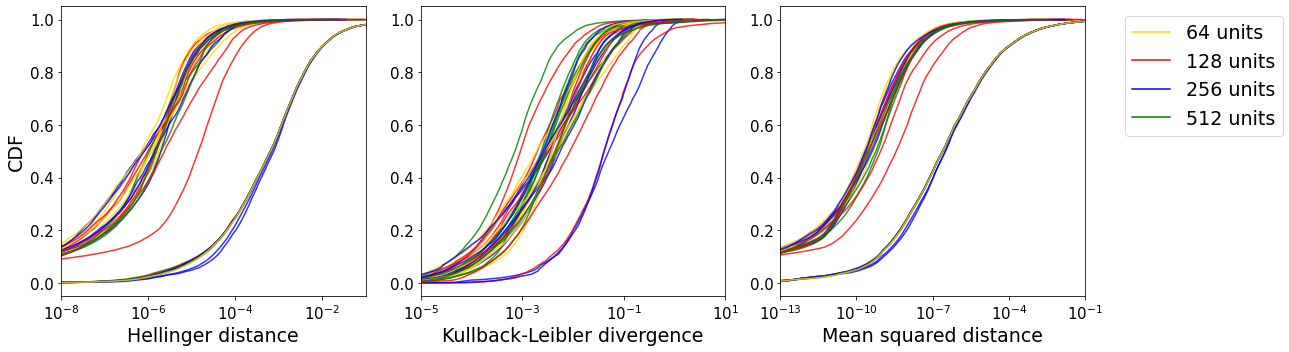

In [51]:
alpha = 0.8
color_options = ['gold','red','blue','green']
units = ['64','128','256','512']
colors = []

for p in all_paths:
    for h,hu in enumerate(units):
        if hu in units:
            colors.append(color_options[h])


    
fig,ax = plt.subplots(1,3,figsize=(18,5))
    
plot_cdf(hell_list,names,colors,alpha,ax[0],legend=False)
ax[0].set_xscale('log')
ax[0].set_xlim(10**-14,10**0)
ax[0].set_xlabel('Hellinger distance',fontsize=fs)
ax[0].set_ylabel('CDF',fontsize=fs)

plot_cdf(kld_list,names,colors,alpha,ax[1],legend=False)
ax[1].set_xscale('log')
ax[1].set_xlim(10**-8,10**1)
ax[1].set_xlabel('Kullback-Leibler divergence',fontsize=fs)
# ax[1].set_ylabel('CDF',fontsize=fs)

plot_cdf(mse_list,names,colors,alpha,ax[2],legend=False)
ax[2].set_xscale('log')
ax[2].set_xlim(10**-13,10**-1)
ax[2].set_xlabel('Mean squared distance',fontsize=fs)
ax[2].set_ylim(-0.05,1.05)
# ax[2].set_ylabel('CDF',fontsize=fs)

for u,lab in enumerate(units):
    ax[2].plot([100,101],[100,101],label=lab + ' units',color=color_options[u])

    
for i in range(3):
    ax[i].tick_params(axis='both',labelsize=15)
    

plt.legend(bbox_to_anchor=[1.1,1.0],fontsize=fs)
plt.tight_layout();

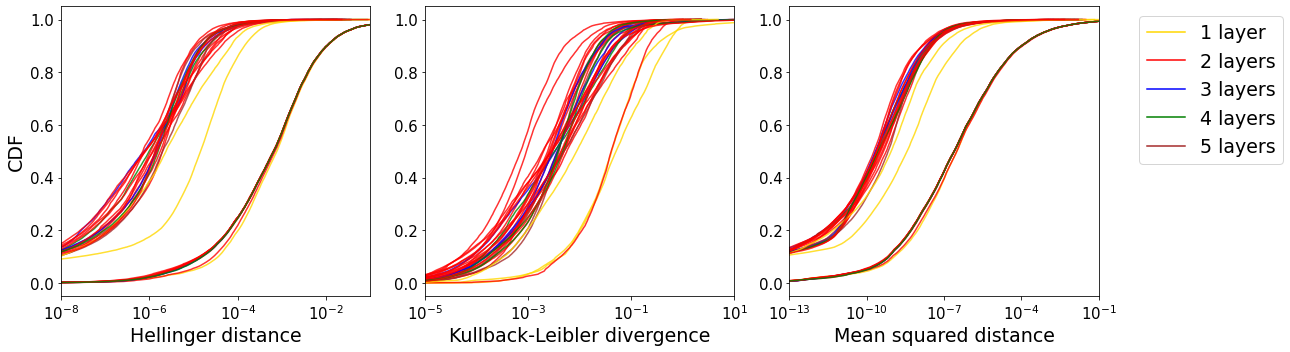

In [57]:
alpha = 0.8
color_options = ['gold','red','blue','green','brown']
layers = ['1 layer','2 layers','3 layers','4 layers','5 layers']
colors = []

for p in names:
    for h,hl in enumerate(layers):
        if hl in p:
            colors.append(color_options[h])

    
fig,ax = plt.subplots(1,3,figsize=(18,5))
    
plot_cdf(hell_list,names,colors,alpha,ax[0],legend=False)
ax[0].set_xscale('log')
ax[0].set_xlim(10**-14,10**0)
ax[0].set_xlabel('Hellinger distance',fontsize=fs)
ax[0].set_ylabel('CDF',fontsize=fs)

plot_cdf(kld_list,names,colors,alpha,ax[1],legend=False)
ax[1].set_xscale('log')
ax[1].set_xlim(10**-8,10**1)
ax[1].set_xlabel('Kullback-Leibler divergence',fontsize=fs)
# ax[1].set_ylabel('CDF',fontsize=fs)

plot_cdf(mse_list,names,colors,alpha,ax[2],legend=False)
ax[2].set_xscale('log')
ax[2].set_xlim(10**-13,10**-1)
ax[2].set_xlabel('Mean squared distance',fontsize=fs)
ax[2].set_ylim(-0.05,1.05)
# ax[2].set_ylabel('CDF',fontsize=fs)

for u,lab in enumerate(layers):
    ax[2].plot([100,101],[100,101],label=lab,color=color_options[u])

    
for i in range(3):
    ax[i].tick_params(axis='both',labelsize=15)
    

plt.legend(bbox_to_anchor=[1.1,1.0],fontsize=fs)
plt.tight_layout();

In [58]:
n = 5
hell_means = np.mean(hell_nn,axis=1)
best_hell_path = np.array(all_paths)[hell_means == min(hell_means)]
sort = np.argsort(hell_means)
print(f'Top {n} for Hellinger')
top_n_hell = np.array(all_paths)[sort][0:n]
print(top_n_hell)
top_n_vals = np.array(hell_means)[sort][0:n]
print(top_n_vals)

Top 5 for Hellinger
['./models/psKWR_models/learn_weights_scale_joint_hellinger/10npdf_2hl_512hu_100bs_0.001lr_no_update_256'
 './models/psKWR_models/learn_weights_scale_joint_hellinger/5npdf_5hl_256hu_100bs_0.001lr_update_256'
 './models/psKWR_models/learn_weights_scale_joint_hellinger/5npdf_2hl_512hu_100bs_0.001lr_update_256'
 './models/psKWR_models/learn_weights_scale_joint_hellinger/5npdf_3hl_256hu_100bs_0.001lr_update_256'
 './models/psKWR_models/learn_weights_scale_joint_hellinger/10npdf_2hl_128hu_100bs_0.001lr_no_update_256']
[9.88878635e-06 1.20729606e-05 1.28346382e-05 1.34607541e-05
 1.35139428e-05]


In [59]:
kld_means = np.mean(kld_nn,axis=1)
best_kld_path = np.array(all_paths)[kld_means == min(kld_means)]
sort = np.argsort(kld_means)
print(f'Top {n} for KLD')
top_n_kld = np.array(all_paths)[sort][0:n]
print(top_n_kld)
top_n_vals = np.array(kld_means)[sort][0:n]
print(top_n_vals)



Top 5 for KLD
['./models/psKWR_models/learn_weights_scale_joint_hellinger/3npdf_2hl_128hu_100bs_0.001lr_no_update_256'
 './models/psKWR_models/learn_weights_scale_joint_hellinger/3npdf_2hl_64hu_100bs_0.001lr_no_update_256'
 './models/psKWR_models/learn_weights_scale_joint_hellinger/3npdf_2hl_256hu_100bs_0.001lr_update_256'
 './models/psKWR_models/learn_weights_scale_joint_hellinger/3npdf_2hl_512hu_100bs_0.001lr_no_update_256'
 './models/psKWR_models/learn_weights_scale_joint_hellinger/3npdf_2hl_64hu_100bs_0.001lr_update_256']
[0.00456927 0.00622407 0.00888773 0.00999326 0.01002163]


In [60]:
mse_means = np.mean(mse_nn,axis=1)
best_mse_path = np.array(all_paths)[mse_means == min(mse_means)]
sort = np.argsort(mse_means)
print(f'Top {n} for MSE')
top_n_mse = np.array(all_paths)[sort][0:n]
print(top_n_mse)
top_n_vals = np.array(mse_means)[sort][0:n]
print(top_n_vals)

Top 5 for MSE
['./models/psKWR_models/learn_weights_scale_joint_hellinger/10npdf_2hl_64hu_100bs_0.001lr_no_update_256'
 './models/psKWR_models/learn_weights_scale_joint_hellinger/5npdf_2hl_128hu_100bs_0.001lr_update_256'
 './models/psKWR_models/learn_weights_scale_joint_hellinger/5npdf_5hl_256hu_100bs_0.001lr_update_256'
 './models/psKWR_models/learn_weights_scale_joint_hellinger/5npdf_2hl_512hu_100bs_0.001lr_update_256'
 './models/psKWR_models/learn_weights_scale_joint_hellinger/5npdf_2hl_256hu_100bs_0.001lr_update_256']
[5.03251120e-07 5.78726220e-07 6.57666826e-07 7.49622472e-07
 7.66876232e-07]



### Figure S4 p: training and validation loss of best over training epochs

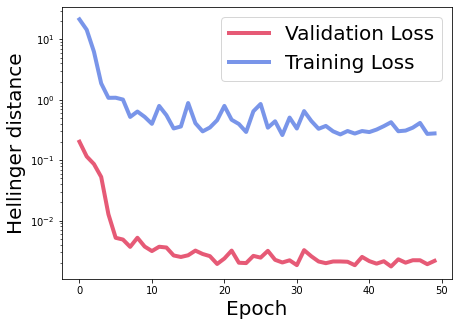

In [61]:
# load in results of best model
best_path = './models/psKWR_models/learn_weights_scale_joint_hellinger/5npdf_2hl_512hu_100bs_0.001lr_update_256'
with open(best_path +'/meta','rb') as file:
    results_dict = pickle.load(file)

fig = plt.figure(figsize=(7,5))

train_hellinger = results_dict['valid_loss']
valid_hellinger = results_dict['train_loss']

fs = 20
lw=4
alpha=0.7

plt.plot(valid_hellinger,label='Validation Loss',c='crimson',linewidth=lw,alpha=alpha)
plt.plot(train_hellinger,label='Training Loss',c='royalblue',linewidth=lw,alpha=alpha)
plt.legend(fontsize=fs)
# plt.title('Training and Validation Loss, Final Model',fontsize=fs)
plt.ylabel('Hellinger distance',fontsize=fs)
plt.xlabel('Epoch',fontsize=fs);
plt.yscale('log')
#plt.savefig('./figs/kld_epoch.png',dpi=450)